In [10]:
import mxnet as mx
import numpy as np

In [11]:
a = mx.nd.array([[1,2,3],[4,5,6]])

In [12]:
{'a.shape':a.shape}

{'a.shape': (2L, 3L)}

In [13]:
a = mx.nd.array(np.arange(6).reshape(6,1))
b = a.broadcast_to((6,4))  #
b.asnumpy()

array([[ 0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.]], dtype=float32)

In [14]:
a.asnumpy()

array([[ 0.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.]], dtype=float32)

In [15]:
c = a.reshape((2,1,1,3))
d = c.broadcast_to((2,2,2,3))
d.asnumpy()

array([[[[ 0.,  1.,  2.],
         [ 0.,  1.,  2.]],

        [[ 0.,  1.,  2.],
         [ 0.,  1.,  2.]]],


       [[[ 3.,  4.,  5.],
         [ 3.,  4.,  5.]],

        [[ 3.,  4.,  5.],
         [ 3.,  4.,  5.]]]], dtype=float32)

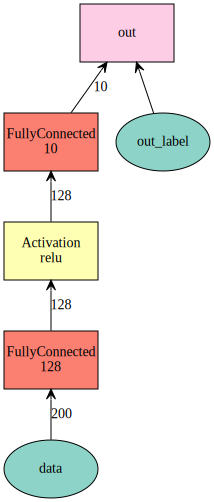

In [17]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=128)
net = mx.sym.Activation(data=net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(data=net, name='out')
mx.viz.plot_network(net, shape={'data':(100,200)})

In [18]:
net = mx.symbol.Variable('data')
w = mx.symbol.Variable('myweight')
net = mx.symbol.FullyConnected(data=net, weight=w, name='fc1', num_hidden=128)
net.list_arguments()

['data', 'myweight', 'fc1_bias']

In [20]:
data = mx.symbol.Variable('data')
net1 = mx.symbol.FullyConnected(data=data, name='fc1', num_hidden=10)
net1.list_arguments()


['data', 'fc1_weight', 'fc1_bias']

In [21]:
net2 = mx.symbol.Variable('data2')
net2 = mx.symbol.FullyConnected(data=net2, name='fc2', num_hidden=10)
composed = net2(data2=net1, name='composed')
composed.list_arguments()

['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias']

In [22]:
data = mx.sym.Variable("data")
net = data
n_layer = 2
for i in range(n_layer):
    with mx.name.Prefix("layer%d_" % (i + 1)):
        net = mx.sym.FullyConnected(data=net, name="fc", num_hidden=100)
net.list_arguments()


['data',
 'layer1_fc_weight',
 'layer1_fc_bias',
 'layer2_fc_weight',
 'layer2_fc_bias']

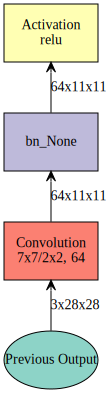

In [23]:
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0),name=None, suffix=''):
    conv = mx.sym.Convolution(data=data, num_filter=num_filter, kernel=kernel,
                  stride=stride, pad=pad, name='conv_%s%s' %(name, suffix))
    bn = mx.sym.BatchNorm(data=conv, name='bn_%s%s' %(name, suffix))
    act = mx.sym.Activation(data=bn, act_type='relu', name='relu_%s%s'
                  %(name, suffix))
    return act
prev = mx.sym.Variable(name="Previous Output")
conv_comp = ConvFactory(data=prev, num_filter=64, kernel=(7,7), stride=(2, 2))
shape = {"Previous Output" : (128, 3, 28, 28)}
mx.viz.plot_network(symbol=conv_comp, shape=shape)

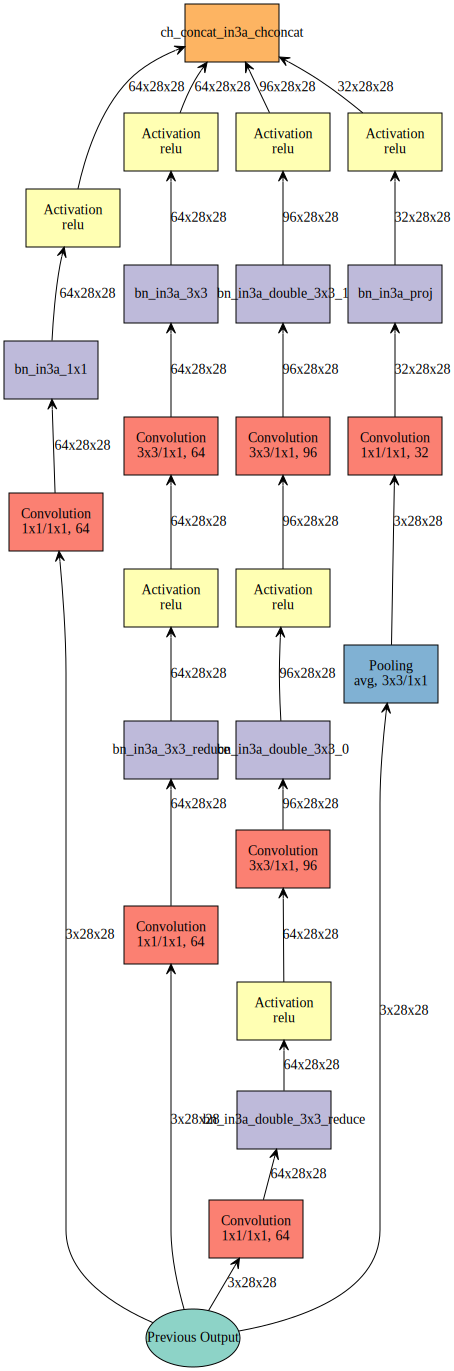

In [24]:
def InceptionFactoryA(data, num_1x1, num_3x3red, num_3x3, num_d3x3red, num_d3x3,
                      pool, proj, name):
    # 1x1
    c1x1 = ConvFactory(data=data, num_filter=num_1x1, kernel=(1, 1), name=('%s_1x1' % name))
    # 3x3 reduce + 3x3
    c3x3r = ConvFactory(data=data, num_filter=num_3x3red, kernel=(1, 1), name=('%s_3x3' % name), suffix='_reduce')
    c3x3 = ConvFactory(data=c3x3r, num_filter=num_3x3, kernel=(3, 3), pad=(1, 1), name=('%s_3x3' % name))
    # double 3x3 reduce + double 3x3
    cd3x3r = ConvFactory(data=data, num_filter=num_d3x3red, kernel=(1, 1), name=('%s_double_3x3' % name), suffix='_reduce')
    cd3x3 = ConvFactory(data=cd3x3r, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_0' % name))
    cd3x3 = ConvFactory(data=cd3x3, num_filter=num_d3x3, kernel=(3, 3), pad=(1, 1), name=('%s_double_3x3_1' % name))
    # pool + proj
    pooling = mx.sym.Pooling(data=data, kernel=(3, 3), stride=(1, 1), pad=(1, 1), pool_type=pool, name=('%s_pool_%s_pool' % (pool, name)))
    cproj = ConvFactory(data=pooling, num_filter=proj, kernel=(1, 1), name=('%s_proj' %  name))
    # concat
    concat = mx.sym.Concat(*[c1x1, c3x3, cd3x3, cproj], name='ch_concat_%s_chconcat' % name)
    return concat
prev = mx.sym.Variable(name="Previous Output")
in3a = InceptionFactoryA(prev, 64, 64, 64, 64, 96, "avg", 32, name="in3a")
mx.viz.plot_network(symbol=in3a, shape=shape)

In [25]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
b = a + a * a

data = mx.nd.ones((2,3))*2
ex = b.bind(ctx=mx.cpu(), args={'a':data, 'b':data})
ex.forward()
ex.outputs[0].asnumpy()

array([[ 6.,  6.,  6.],
       [ 6.,  6.,  6.]], dtype=float32)

In [28]:
import logging
logging.getLogger().setLevel(logging.INFO)
import mxnet as mx
import numpy as np

fname = mx.test_utils.download('http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data')
data = np.genfromtxt(fname, delimiter=',')[:,1:]

INFO:root:downloaded http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data into letter-recognition.data successfully


In [29]:
data

array([[  2.,   8.,   3., ...,   8.,   0.,   8.],
       [  5.,  12.,   3., ...,   8.,   4.,  10.],
       [  4.,  11.,   6., ...,   7.,   3.,   9.],
       ..., 
       [  6.,   9.,   6., ...,  12.,   2.,   4.],
       [  2.,   3.,   4., ...,   9.,   5.,   8.],
       [  4.,   9.,   6., ...,   7.,   2.,   8.]])

In [30]:
label = np.array([ord(l.split(',')[0])-ord('A') for l in open(fname, 'r')])

batch_size = 32
ntrain = int(data.shape[0]*0.8)
train_iter = mx.io.NDArrayIter(data[:ntrain, :], label[:ntrain], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data[ntrain:, :], label[ntrain:], batch_size)

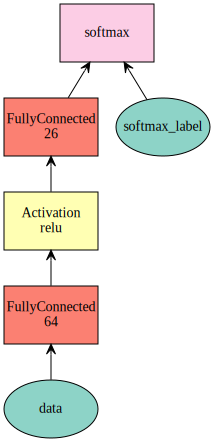

In [32]:
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(net, name='softmax')
mx.viz.plot_network(net)


In [33]:
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu(),
                    data_names=['data'],
                    label_names=['softmax_label'])


In [34]:
# allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
# initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=.1))
# use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1), ))
# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs, i.e. going over the data iter one pass
for epoch in range(5):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    print('Epoch %d, Training %s' % (epoch, metric.get()))

Epoch 0, Training ('accuracy', 0.4631875)
Epoch 1, Training ('accuracy', 0.6609375)
Epoch 2, Training ('accuracy', 0.714)
Epoch 3, Training ('accuracy', 0.749125)
Epoch 4, Training ('accuracy', 0.775125)


In [35]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'w')
for i in range(5):
    record.write_idx(i, 'record_%d'%i)
record.close()

In [36]:
record = mx.recordio.MXIndexedRecordIO('tmp.idx', 'tmp.rec', 'r')
record.read_idx(3)

'record_3'